(hgf_exercises_2)=
# Applying the Hierarchical Gaussian Filter to reinforcement learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Exercise_1_Using_the_HGF.ipynb)

In [16]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install phygf watermark

In [17]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF
from pyhgf.response import binary_softmax
from pytensor import scan

In [18]:
# load an example time series for continuous inputs
timeseries = load_data("continuous")

## Bayesian reinforcement learning: the binary HGF

In the first part of the tutorial, we introduced the continuous Hierarchical Gaussian Filter and detailed how it is built on top of hierarchical GRW. This model is intended to work with continuous input variables. In this regard, it can be seen as a generalization of the Kalman filter. However, several experiments require working with variables that have discrete states.

The binary HGF can be seen as an extension of the continuous HGF, with the exception that it has a binary input node except one a continuous one. Handling such binary variables can be useful, for example for reinforcement learning paradigms where we want the agent to learn the association between two states in the world. Such experiments, like the [one-armed badit task](https://en.wikipedia.org/wiki/Multi-armed_bandit) that we will be using below, generally produce two types of information at each trial:
- the action $y$, as a boolean variable, that is registering the decision made by the agent at time $t$, at the beginning of the trial.
- the observation $u$ about the association between the stimuli and the outcomes, as a boolean (e.g. `1` if Stim_1 -> Outcome_1 and Stim_2 -> Outcome_2, `0` otherwise). 

We can load an example dataset from {cite:p}`Iglesias2021` using the following command that will return a vector of observations $u$ and a vector of decision $y$.

In [19]:
u, y = load_data("binary")

### The binary Hierarchical Gaussian Filter

Fitting data to a binary HGF is quite similar to the continuous one (note that ```model_type="binary"```).

In [20]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="binary",
    initial_mean={"1": 0.0, "2": 0.0},
    initial_precision={"1": np.nan, "2": 1.0},
    tonic_volatility={"2": -5},
)

This is a two-level binary HGF, so we have one continuous node predicting the outcomes of a binary state node.

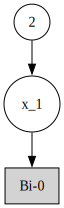

In [21]:
two_levels_hgf.plot_network()

The observations about the associations are provided as input data and will be the sensory information the agent uses to update its beliefs.

In [22]:
two_levels_hgf = two_levels_hgf.input_data(input_data=u)

The node trajectories illustrate how new binary outcomes change the expectations about the associations between the stimuli.

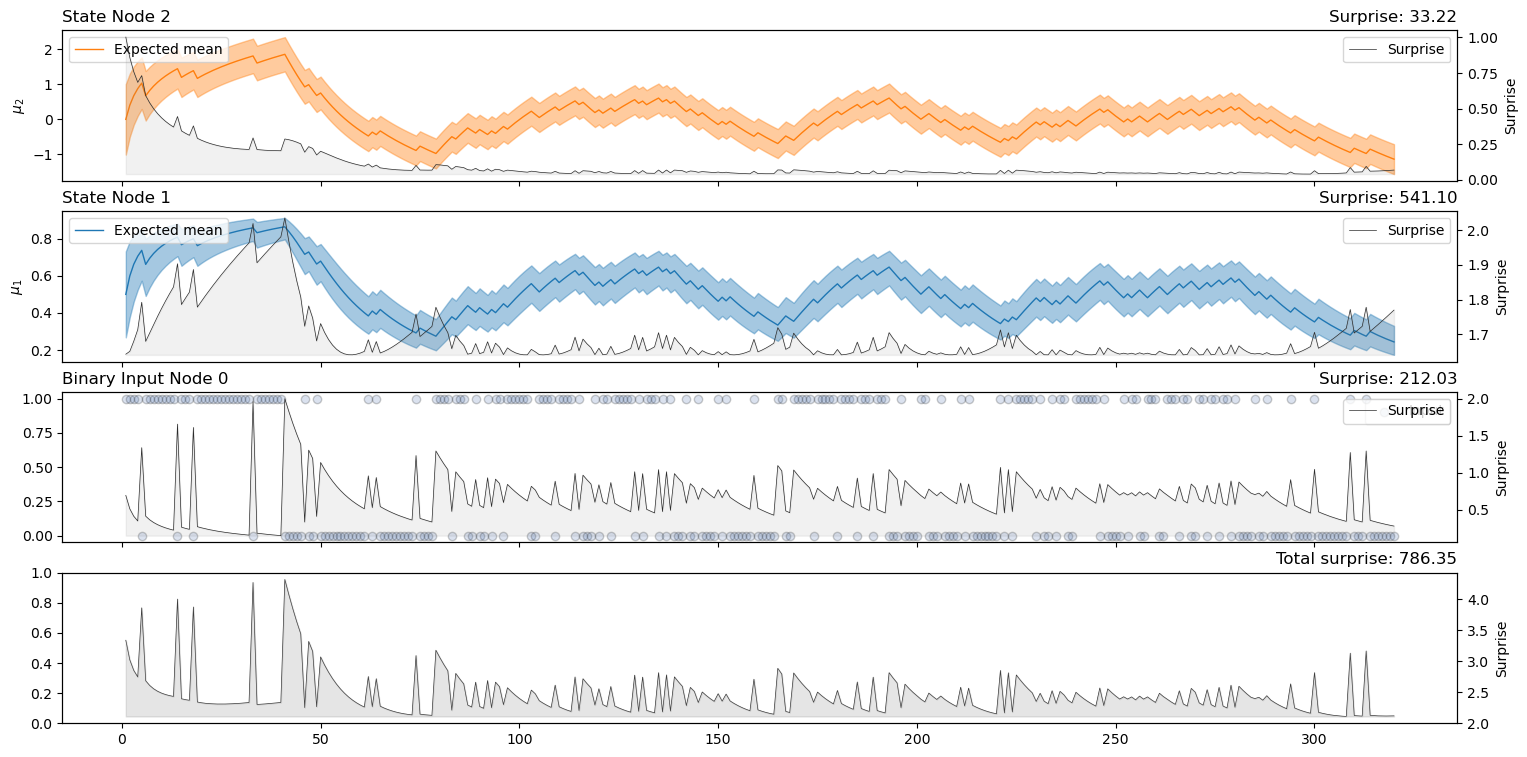

In [23]:
two_levels_hgf.plot_trajectories();

We now have a model with beliefs trajectories and we want to see how these beliefs can explain the behaviour of the participant. This is where we will use the decision vector $y$ together with a response model. Designing response models that are adapted to the task is a central part of the modelling process (you can read more on this in the {ref}`custom_response_functions` section). Here, we use the `binary_softmax`, which means that we assume the expected probability at the first level of the model predicts the decision.

In [24]:
two_levels_hgf.surprise(
    response_function=binary_softmax,  # the response model
    response_function_inputs=y,  # the decision vector
)

Array(182.46234, dtype=float32)

Once we have these two piece of information, we are ready to compute the surprise, which will indicates how well our model could prediction the behavior of the participant.

```{hint}
The actions, or decisions, initiated by the agent are not influencing the way beliefs about the hidden states of the world are being updated (this is NOT active inference). This is for sure a limitation of the model, but it also means that the belief updating and the response model can be processed separately. In other words, no matter what actions the agent is taking along the way, this will not change the way sensory evidence is updating beliefs.
```

```{admonition} Exercises 5
- Using the examples above, can you diagnose the performances of the agent?
- What could make it better?
- Can you try to change the parameters and get an agent with better performances (i.e. minimizing the surprise)?
```

### Model comparison

When modelling, we always want to control for alternative, simpler explanations. It might be that our subjects are dynamically updating their beliefs in accordance with our assumptions. However, sometimes, they might just be responding rather randomly and not show much learning at all. It might also be that they are using a simple learning model that does not require to use of the HGF to capture higher-order volatility. We want to analyse the data using all these models and compare how well they can explain the participant's responses.

#### Biased random

To control for this possibility, we define the simpler alternative model below. This model just takes random actions with a single fixed probability. It does not integrate the data from the task at all.

In [25]:
with pm.Model() as biased_random_model:

    # a simple bias toward deciding 1 vs. 0
    bias = pm.Beta("bias", 1.0, 1.0)

    # Likelihood of observed rewards given the value estimates
    likelihood = pm.Bernoulli("likelihood", p=bias, observed=y)

    # sample from this model
    biased_random_idata = pm.sample(
        chains=4, cores=4, idata_kwargs={"log_likelihood": True}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [bias]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


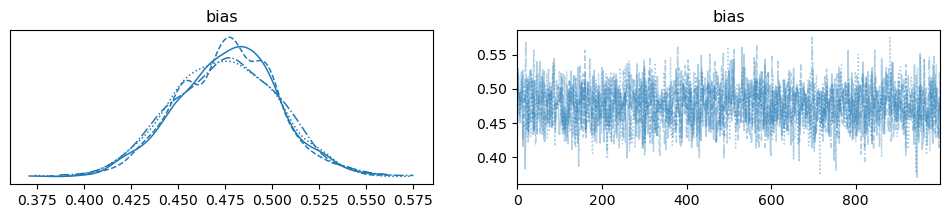

In [26]:
az.plot_trace(biased_random_idata);

Assess model fitting, here using leave-one-out cross-validation from the [Arviz](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) library.

In [27]:
az.loo(biased_random_idata)

Computed from 4000 posterior samples and 320 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -222.40     0.88
p_loo        1.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      320  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### Rescorla-Wagner

Another popular model in reinforcement learning is the [Rescorla-Wagner model](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model), which assumes that the agent uses prediction errors from the previous observation to update its beliefs. Here we create a simple Rescorla-Wagner and try to optimize the learning rate to predict the agent decisions.

Here, we write our models using [PyTensor](https://pytensor.readthedocs.io/en/latest/), which is the tensor library on which [PyMC](https://www.pymc.io/welcome.html) is built, and sample the model the same way. We start by creating a log probability function, that measures the model error when observing the response data.

In [28]:
def rw_update(new_observation, current_belief, learning_rate):
    """Update the belief about contingencies at time t."""

    # get the new value using the RW update
    new_belief = current_belief + learning_rate * (new_observation - current_belief)

    return new_belief

In [29]:
with pm.Model() as rw_model:

    observations = pt.as_tensor_variable(u, dtype="int32")
    initial_belief = pm.Beta("initial_belief", 1.0, 1.0)

    # prior over the learning rate
    learning_rate = pm.Beta("learning_rate", 1, 0, 1.0)

    # Apply the Rescorla-Wagner update rule to the sequence of observations
    beliefs, _ = scan(
        fn=rw_update,
        sequences=observations,
        non_sequences=learning_rate,
        outputs_info=initial_belief,
    )

    # compute the likelihood at each trial using a simple sigmoid as response function
    likelihood = pm.Bernoulli("likelihood", p=beliefs, observed=y)

In [30]:
with rw_model:
    rw_idata = pm.sample(chains=4, cores=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'initial_belief_logodds__': array(0.94675066), 'learning_rate_logodds__': array(inf)}

Logp initial evaluation results:
{'initial_belief': -1.6, 'learning_rate': -inf, 'likelihood': -inf}
You can call `model.debug()` for more details.

In [ ]:
az.plot_trace(rw_idata);

In [ ]:
az.loo(rw_idata)

We can visualize the belief updating using this model as:

In [ ]:
learning_rate = az.summary(rw_idata)["mean"].lr


def rw_update(new_observation, current_belief):

    # sigmoid transform the beliefs at t-1 (into [0,1])
    transformed_old_value = 1 / (1 + np.exp(-current_belief))

    # get the new value using the RW update
    new_belief = current_belief + learning_rate * (
        new_observation - transformed_old_value
    )

    return new_belief


beliefs = [0.0]
for i in u:
    new_belief = rw_update(i, beliefs[-1])
    beliefs.append(new_belief)
beliefs = 1 / (1 + np.exp(-np.array(beliefs)))

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(beliefs, label="R-W belief updates")
plt.scatter(np.arange(len(u)), u, alpha=0.4, edgecolor="k")
plt.legend()
sns.despine()

#### Two-level HGF

Finally, we can model the behaviour using the two-level or the three-level HGF. The two-level model should generate prediction similar to what we have with the Rescorla-Wagner model, while the three-level HGF is adding a layer of volatility and therefore could take advantage of higher-level dynamics of volatility.

In [ ]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=binary_softmax,
    response_function_inputs=y[np.newaxis, :],
)

In [ ]:
def logp(value, tonic_volatility_2):
    return hgf_logp_op(tonic_volatility_2=tonic_volatility_2)

In [ ]:
with pm.Model() as two_levels_binary_hgf:
    y_data = pm.Data("y_data", y)
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -5.0, 2.0)
    hgf = pm.DensityDist("hgf", tonic_volatility_2, logp=logp, observed=y_data)

In [ ]:
with two_levels_binary_hgf:
    two_levels_idata = pm.sample(
        chains=4, cores=1, idata_kwargs={"log_likelihood": True}
    )

In [ ]:
az.plot_trace(two_levels_idata);

In [ ]:
%%capture --no-display
az.loo(two_levels_idata)

#### Three-level HGF

In [ ]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=binary_softmax,
    response_function_inputs=y[np.newaxis, :],
)

In [ ]:
def logp(value, tonic_volatility_2):
    return hgf_logp_op(
        tonic_volatility_2=tonic_volatility_2, tonic_volatility_3=-6.0, mean_3=1.0
    )

In [ ]:
with pm.Model() as three_levels_binary_hgf:
    y_data = pm.Data("y_data", y)
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -5.0, 2.0)
    hgf = pm.DensityDist("hgf", tonic_volatility_2, logp=logp, observed=y_data)

In [ ]:
with three_levels_binary_hgf:
    three_levels_idata = pm.sample(
        chains=4, cores=1, idata_kwargs={"log_likelihood": True}
    )

In [ ]:
az.plot_trace(three_levels_idata)
plt.tight_layout();

In [ ]:
%%capture --no-display
az.loo(three_levels_idata)

In [ ]:
%%capture --no-display
az.compare(
    {
        "biased_random": biased_random_idata,
        "RW": rw_idata,
        "two-level": two_levels_idata,
        "three-level": three_levels_idata,
    }
)

### Posterior predictive sampling

Another way to assess model fitting is to use a posterior predictive check (i.e. we want to ensure that the posterior distribution would be well suited to predict the data at hand). This is usually done by sampling from the posterior distribution and comparing it with the observations. We can do something that approaches this procedure by sampling the parameters of the HGF from the posterior distribution obtained in the previous steps and plotting the resulting trajectories. We can retrieve the parameters of the posterior distributions from our previous fit:

And use them to sample new parameters from the same distribution and plot the beliefs trajectories accordingly:

In [ ]:
fig, axs = plt.subplots(nrows=4, figsize=(12, 7))

for _ in range(20):

    tonic_volatility_2 = np.random.normal(
        az.summary(three_levels_idata)["mean"].tonic_volatility_2,
        az.summary(three_levels_idata)["sd"].tonic_volatility_2,
    )

    three_levels_df = (
        HGF(
            n_levels=3,
            model_type="binary",
            initial_mean={"1": 0.0, "2": 0.0, "3": 1.0},
            initial_precision={"1": 0.0, "2": 1.0, "3": 1.0},
            tonic_volatility={"2": tonic_volatility_2, "3": -6.0},
            verbose=False,
        )
        .input_data(input_data=u)
        .to_pandas()
    )

    axs[0].plot(
        three_levels_df.time,
        three_levels_df.x_3_expected_mean,
        alpha=0.4,
        linewidth=0.5,
        color="#c44e52",
    )

    axs[1].plot(
        three_levels_df.time,
        three_levels_df.x_2_expected_mean,
        alpha=0.4,
        linewidth=0.5,
        color="#55a868",
    )

    axs[2].plot(
        three_levels_df.time,
        three_levels_df.x_1_expected_mean,
        alpha=0.4,
        linewidth=0.5,
        color="#4c72b0",
    )

    axs[3].plot(
        three_levels_df.time,
        three_levels_df.total_surprise,
        alpha=0.4,
        linewidth=0.5,
        color="#2a2a2a",
    )

axs[2].scatter(
    three_levels_df.time, three_levels_df.observation_input_0, alpha=0.4, edgecolor="k"
)
axs[3].set_title("Surprise", loc="left")
plt.tight_layout()
sns.despine()

# System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib